<a href="https://colab.research.google.com/github/ngabo-dev/parents_feedback-analysis/blob/main/parents'_feedback_to_schools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup and Install Dependencies**

In [17]:
!pip install -q nltk scikit-learn

**Import Libraries**

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import string
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

**Download NLTK Resources**

In [19]:
# Download NLTK data files for stopwords and lemmatization
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Load Dataset**

In [20]:
# Load the dataset from your Google Drive or upload directly
# For example, if you uploaded the file to Colab:
df = pd.read_csv('parent_feedback_dataset.csv')

# Show first 5 rows to understand the data
df.head()

,Feedback_ID,Parent_Feedback,Sentiment_Label,Submission_Date,School_ID
0,1,I appreciate the regular updates on my child’s...,Positive,2025-01-24,1005
1,2,The administration is slow to respond to paren...,Negative,2025-04-05,1001
2,3,The school library has a great selection of bo...,Positive,2025-03-17,1004
3,4,The school environment is welcoming and inclus...,Positive,2025-01-08,1004
4,5,The school’s holiday events are fun for the wh...,Positive,2025-01-22,1005


**Explore Dataset**

In [21]:
# Check distribution of sentiment labels
print("Sentiment label counts:")
print(df['Sentiment_Label'].value_counts())

Sentiment label counts:
Sentiment_Label
Positive    1525
Negative    1475
Name: count, dtype: int64


**Text Preprocessing Function**

In [22]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define text preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = [word for word in text.split() if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

# Apply preprocessing to the feedback column
df['clean_feedback'] = df['Parent_Feedback'].apply(preprocess_text)

# Show sample of cleaned text
df[['Parent_Feedback', 'clean_feedback']].head()

,Parent_Feedback,clean_feedback
0,I appreciate the regular updates on my child’s...,appreciate regular update child’s progress
1,The administration is slow to respond to paren...,administration slow respond parent concern
2,The school library has a great selection of bo...,school library great selection book
3,The school environment is welcoming and inclus...,school environment welcoming inclusive
4,The school’s holiday events are fun for the wh...,school’s holiday event fun whole family


**Encode Sentiment Labels**

In [23]:
# Convert sentiment labels (Positive/Negative) to numeric values
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['Sentiment_Label'])

print("Encoded classes:", le.classes_)
df[['Sentiment_Label', 'sentiment_encoded']].head()

Encoded classes: ['Negative' 'Positive']


,Sentiment_Label,sentiment_encoded
0,Positive,1
1,Negative,0
2,Positive,1
3,Positive,1
4,Positive,1


**Split Dataset into Training and Testing Sets**

In [24]:
# Define features and target
X = df['clean_feedback']
y = df['sentiment_encoded']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 2400
Testing samples: 600


**Vectorize Text Data with TF-IDF**

In [25]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit on training data and transform both train and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Save the fitted vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print(f"Number of features: {X_train_tfidf.shape[1]}")

Number of features: 183


**Training Logistic Regression Model**

In [26]:
# Initialize and train Logistic Regression classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Save the trained model as a pickle file
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model training completed.")

Model training completed.


**Evaluation of Model Performance**

In [27]:
# Predict on test data
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy on test set: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       288
    Positive       1.00      1.00      1.00       312

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



**Confusion Matrix Visualization**

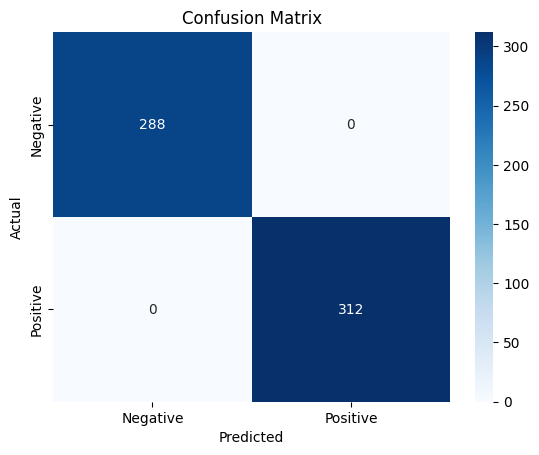

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()